In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def uncensoring_KPI(dataframe, method_name):
    """
    Calculate KPIs for demand forecasting evaluation
    
    Parameters:
    - dataframe: pandas DataFrame containing 'Verkauf' (predicted) and 'Verkauf_MBR' (ground truth) columns
    - method_name: string name of the method being evaluated
    - censorship_pct: censorship percentage for display
    - reduction_pct: reduction percentage for display
    - alpha: weight parameter for Weighted MAE (default=1)
            α = 0: standard MAE (no weighting)
            α = 1: linear weighting by true demand
            α > 1: over-proportional penalization of larger errors
            α < 1: emphasis on smaller demands
    """
    df = dataframe[dataframe['Zensiert']==1]
    censored_fraction = len(df)/len(dataframe)
    
    # Extract predicted and true values
    y_pred = df[method_name + "_Demand"].values  # ŷᵢ (estimated demand)
    y_true = df['Verkauf_MBR'].values  # yᵢ (true demand)
    
    n = len(y_pred)
    if n == 0: return
    
    # 1. Bias calculation
    bias = np.sum(y_pred - y_true) / n
    
    # 2. Accuracy (exact matches)
    exact_matches = np.sum(y_pred == y_true)
    accuracy = exact_matches / n
    
    # 3. Overestimation Rate
    overestimations = np.sum(y_pred > y_true)
    overestimation_rate = overestimations / n
    
    # 4. Underestimation Rate
    underestimations = np.sum(y_pred < y_true)
    underestimation_rate = underestimations / n
    
    # 5. Weighted MAE
    alphas = [0, 0.5, 1, 1.5]
    weighted_maes = {}
    for a in alphas:
        if a == 0:
            # Standard MAE (no weighting)
            weighted_maes[a] = np.mean(np.abs(y_pred - y_true))
        else:
            # Weighted MAE with α parameter
            weights = np.power(y_true, a)
            # Handle case where y_true might be 0
            weights = np.where(y_true == 0, 0, weights)
            weighted_maes[a] = np.sum(weights * np.abs(y_pred - y_true)) / np.sum(weights) if np.sum(weights) > 0 else 0

    # 6. Gini Coefficient
    abs_errors = np.abs(y_pred - y_true)
    mean_abs_error = np.mean(abs_errors)
    n = len(abs_errors)
    sorted_errors = np.sort(abs_errors)
    
    weighted_sum = 0.0
    total_sum = 0.0
    
    for i in range(n):
        weighted_sum += (i + 1) * sorted_errors[i]
        total_sum += sorted_errors[i]
    
    gini_coefficient = (2 * weighted_sum) / (n * total_sum) - (n + 1) / n
    
    # 7. Overstock, out of curiosity
    overstock = np.sum(np.maximum(0, y_pred - y_true))

    for i in range(n):
        weighted_sum += (i + 1) * sorted_errors[i]
        total_sum += sorted_errors[i]

    gini_coefficient = (2 * weighted_sum) / (n * total_sum) - (n + 1) / n

    # Determine bias direction
    bias_direction = "overestimation" if bias > 0 else "underestimation" if bias < 0 else "neutral"
    
    # Print results in the specified format
    #print(f"Method: {method_name}, on {path}")
    # print(f"- Bias: {bias:.3f} ({bias_direction})")
    # print(f"- Weighted MAE (α=0): {weighted_maes[0]:.3f}")
    # print(f"- Weighted MAE (α=0.5): {weighted_maes[0.5]:.3f}")
    # print(f"- Weighted MAE (α=1): {weighted_maes[1]:.3f}")
    # print(f"- Weighted MAE (α=1.5): {weighted_maes[1.5]:.3f}")
    # print(f"- Accuracy (exact matches): {accuracy:.3f}")
    # print(f"- Overestimation Rate: {overestimation_rate:.3f}")
    # print(f"- Underestimation Rate: {underestimation_rate:.3f}")
    # print(f"- Gini Coefficient: {gini_coefficient:.3f}")
    # print(f"Overstock: {int(overstock)}")
    
    return {
        method_name+'_bias': bias,
        method_name+'_weighted_mae_0': weighted_maes[0],
        method_name+'_weighted_mae_0.5': weighted_maes[0.5],
        method_name+'_weighted_mae_1': weighted_maes[1],
        method_name+'_weighted_mae_1.5': weighted_maes[1.5],
        method_name+'_censored_fraction': censored_fraction,
        method_name+'_accuracy': accuracy,
        method_name+'_overestimation_rate': overestimation_rate,
        method_name+'_underestimation_rate': underestimation_rate,
        method_name+'_gini_coefficient': gini_coefficient,
        method_name+'_overstock': overstock
        }

def uncensoring_KPI_date(df, method_name):
    ''''
    Calculate uncensoring KPIs grouped by date.
    Returns dataframe indexed by date with KPI values and prints KPIs averaged across all date
    '''
    df=df.dropna()
    
    KPIs = []
    for date, group in df.groupby(df['Date']):
        date_result = uncensoring_KPI(group, method_name)

        #check for None output when nothing is censored
        if date_result is not None:
            date_result['Date'] = date #add date to output dictionary
            KPIs.append(date_result)

    df_KPI_date = pd.DataFrame(
        data = KPIs,
        columns = ['bias', 'weighted_mae_0', 'weighted_mae_0.5','weighted_mae_1', 'weighted_mae_1.5', 'censored_fraction',
                'accuracy', 'overestimation_rate','underestimation_rate','gini_coefficient','overstock', 'Date'])
    df_KPI_date = df_KPI_date.set_index('Date').sort_index()

    #print final averaged results
    print("KPIs by date, averaged over all dates")
    for col in df_KPI_date.columns:
        print(f'{col}: {df_KPI_date[col].mean():.3f}')
    return df_KPI_date

def uncensoring_KPI_POS(df, method_name):
    ''''
    Calculate uncensoring KPIs grouped by POS.
    Returns dataframe indexed by POS with KPI values and prints KPIs averaged across all POS
    '''
    df=df.dropna()
    
    KPIs = []
    for pos, group in df.groupby('EHASTRA_EH_NUMMER'):
        #do not calculate KPI for POS with less than 3 uncensored points
        if len(group[group['Zensiert']==1])<3: continue
        pos_result = uncensoring_KPI(group, method_name)

        #check for None output when nothing is censored
        if pos_result is not None:
            pos_result['POS'] = pos #add POS to output dictionary
            KPIs.append(pos_result)

    df_KPI_pos = pd.DataFrame(
        data = KPIs,
        columns = [method_name+'_bias', method_name+'_weighted_mae_0', method_name+'_weighted_mae_0.5',method_name+'_weighted_mae_1',
                    method_name+'_weighted_mae_1.5', method_name+'_censored_fraction', method_name+'_accuracy', method_name+'_overestimation_rate',
                    method_name+'_underestimation_rate',method_name+'_gini_coefficient',method_name+'_overstock', 'POS'])
    df_KPI_pos = df_KPI_pos.set_index('POS')

    #print final averaged results
    print("KPIs by POS, averaged over all POS")
    for col in df_KPI_pos.columns:
        print(f'{col}: {df_KPI_pos[col].mean():.3f}')
    return df_KPI_pos

def uncensoring_KPI_Bezug(df, method_name):
    ''''
    Calculate uncensoring KPIs grouped by Bezug.
    Returns dataframe indexed by Bezug with KPI values and prints KPIs averaged across all Bezug
    '''
    df.drop(method_name+"_Q", axis='columns', inplace=True)
    df=df.dropna()

    KPIs = []
    for key, group in df.groupby('Bezug'):
        group_result = uncensoring_KPI(group, method_name)
        if group_result is not None:
            group_result['Bezug'] = key
            KPIs.append(group_result)
    df_KPI_Bezug = pd.DataFrame(data=KPIs,
                        columns=[method_name+'_bias', method_name+'_weighted_mae_0', method_name+'_weighted_mae_0.5',method_name+'_weighted_mae_1',
                                method_name+'_weighted_mae_1.5', method_name+'_censored_fraction', method_name+'_accuracy',
                                method_name+'_overestimation_rate',method_name+'_underestimation_rate',method_name+'_gini_coefficient',
                                method_name+'_overstock', 'Bezug'])
    df_KPI_Bezug = df_KPI_Bezug.set_index('Bezug')

    #print final averaged results
    print("KPIs by Bezug, averaged over all Bezug")
    for col in df_KPI_Bezug.columns:
        print(f'{col}: {df_KPI_Bezug[col].mean():.3f}')
    return df_KPI_Bezug

def sales_KPI(df, method_name, c_ratio):
    '''
    Calculate KPIs for sales evaluation using quantity suggested by method
    Parameters:
    - df: pandas DataFrame indexed by date, must have columns: '(Method Name)_Q' (predicted) and 'Verkauf_MBR' (ground truth)
    - method_name: string name of the method being evaluated

    Output:
    OOS rate, alpha service level, beta rate, lost sales, and pinball_loss over all rows
    '''
    def pinball_loss_calculator(row):
        if row['Verkauf_MBR'] >= row[method_name+'_Q']: return c_ratio*(row['Verkauf_MBR']-row[method_name+'_Q'])
        else: return (1-c_ratio)*(-row['Verkauf_MBR']+row[method_name+'_Q'])

    df = df.dropna()
    df['OOS'] = df['Verkauf_MBR']>df[method_name+"_Q"]
    df['beta'] = df.apply(lambda row: min(row['Verkauf_MBR'], row[method_name+"_Q"])/row['Verkauf_MBR'] if row['Verkauf_MBR']!=0 else None, axis=1)
    df['lost_sales'] = df.apply(lambda row: np.abs(row['Verkauf_MBR']-row[method_name+'_Q']), axis=1)
    df['pinball_loss'] = df.apply(pinball_loss_calculator, axis=1)

    OOS_rate = df['OOS'].mean()
    alpha_level = 1 - OOS_rate
    beta_rate = df['beta'].mean()
    lost_sales = df['lost_sales'].sum()
    pinball_loss = df['pinball_loss'].mean()
    
    return {
        method_name + '_OOS_rate' : OOS_rate,
        method_name + '_beta_rate': beta_rate,
        method_name + '_alpha_level' : alpha_level,
        method_name + '_lost_sales': lost_sales,
        method_name + '_pinball_loss': pinball_loss
    }

def sales_KPI_POS(df, method_name, c_ratio):
    ''''
    Calculate sales KPIs grouped by POS.
    Returns dataframe indexed by POS with KPI values and prints KPIs averaged across all POS
    '''
    df=df.dropna()
    
    KPIs = []
    for pos, group in df.groupby('EHASTRA_EH_NUMMER'):
        #do not calculate KPI for POS with less than 3 uncensored points
        if len(group[group['Zensiert']==1])<3: continue
        pos_result = sales_KPI(group, method_name, c_ratio)

        #check for None output when nothing is censored
        if pos_result is not None:
            pos_result['EHASTRA_EH_NUMMER'] = pos #add POS to output dictionary
            KPIs.append(pos_result)

    df_KPI_pos = pd.DataFrame(data = KPIs)
    df_KPI_pos = df_KPI_pos.set_index('EHASTRA_EH_NUMMER')

    #print final averaged results
    print("KPIs by POS, averaged over all POS")
    for col in df_KPI_pos.columns:
        print(f'{col}: {df_KPI_pos[col].mean():.3f}')
    return df_KPI_pos

In [21]:
#Sales KPI by POS
for letter in 'ABCDEFGHI':
    print(letter)
    df = pd.read_csv('result_files/'+letter+'_20250212_ZQ0.35_ZG0.4_testfile_Agrawal_Bezug_Inventory.csv')
    df = df[df['Heftjahr']==2024]
    df_sales_kpi = sales_KPI_POS(df, "Agrawal", 0.9)
    df_sales_kpi.to_csv('KPI_results/'+letter+'_20250212_ZQ0.35_ZG0.4_testfile_Agrawal_Bezug_KPI_sales.csv')

A
KPIs by POS, averaged over all POS
Agrawal_OOS_rate: 0.048
Agrawal_beta_rate: 0.987
Agrawal_alpha_level: 0.952
Agrawal_lost_sales: 74.455
Agrawal_pinball_loss: 0.318
B
KPIs by POS, averaged over all POS
Agrawal_OOS_rate: 0.058
Agrawal_beta_rate: 0.984
Agrawal_alpha_level: 0.942
Agrawal_lost_sales: 69.902
Agrawal_pinball_loss: 0.316
C
KPIs by POS, averaged over all POS
Agrawal_OOS_rate: 0.067
Agrawal_beta_rate: 0.977
Agrawal_alpha_level: 0.933
Agrawal_lost_sales: 55.696
Agrawal_pinball_loss: 0.273
D
KPIs by POS, averaged over all POS
Agrawal_OOS_rate: 0.156
Agrawal_beta_rate: 0.932
Agrawal_alpha_level: 0.844
Agrawal_lost_sales: 20.894
Agrawal_pinball_loss: 0.359
E
KPIs by POS, averaged over all POS
Agrawal_OOS_rate: 0.100
Agrawal_beta_rate: 0.957
Agrawal_alpha_level: 0.900
Agrawal_lost_sales: 23.587
Agrawal_pinball_loss: 0.510
F
KPIs by POS, averaged over all POS
Agrawal_OOS_rate: 0.126
Agrawal_beta_rate: 0.948
Agrawal_alpha_level: 0.874
Agrawal_lost_sales: 22.799
Agrawal_pinball_loss

In [ ]:
# Calculate uncensoring KPIs averaged over everything and by Bezug
# Groups with no uncensored points are skipped
for letter in 'A':
    df=pd.read_csv('result_files/'+letter+'_20250212_ZQ0.35_ZG0.4_testfile_Bayesian_Poisson_Beta(1,1)_Bezug.csv', delimiter=",", index_col='Period')
    #KPI by Bezug
    df_KPI_Bezug = uncensoring_KPI_Bezug(df, 'Bayesian_Poisson')
    #df_KPI_Bezug.to_csv('KPI_results/'+letter+'_20250212_ZQ0.35_ZG0.4_testfile_Agrawal_Bezug_KPI_Bezug.csv', index_label='Bezug')

    #KPI over all
    dict_KPI = uncensoring_KPI(df, "Bayesian_Poisson")
    print('KPI averaged over all:')
    for kpi, value in dict_KPI.items():
        print(f"{kpi}: {value:.3f}")

KPIs by Bezug, averaged over all Bezug
Bayesian_Poisson_bias: -6.873
Bayesian_Poisson_weighted_mae_0: 8.229
Bayesian_Poisson_weighted_mae_0.5: 8.406
Bayesian_Poisson_weighted_mae_1: 8.594
Bayesian_Poisson_weighted_mae_1.5: 8.792
Bayesian_Poisson_censored_fraction: 0.105
Bayesian_Poisson_accuracy: 0.006
Bayesian_Poisson_overestimation_rate: 0.068
Bayesian_Poisson_underestimation_rate: 0.926
Bayesian_Poisson_gini_coefficient: 0.260
Bayesian_Poisson_overstock: 7.857
KPI averaged over all:
Bayesian_Poisson_bias: -4.334
Bayesian_Poisson_weighted_mae_0: 4.377
Bayesian_Poisson_weighted_mae_0.5: 4.783
Bayesian_Poisson_weighted_mae_1: 5.260
Bayesian_Poisson_weighted_mae_1.5: 5.816
Bayesian_Poisson_censored_fraction: 0.134
Bayesian_Poisson_accuracy: 0.000
Bayesian_Poisson_overestimation_rate: 0.002
Bayesian_Poisson_underestimation_rate: 0.998
Bayesian_Poisson_gini_coefficient: 0.295
Bayesian_Poisson_overstock: 275.000


In [ ]:
# For decision tree, calculate uncensoring KPI by POS
# drop POS with <3 uncensored points
for letter in 'ABCDEFGHI':
    print(f"Results for Magazine {letter}")
    df=pd.read_csv('result_files/'+letter+'_20250212_ZQ0.35_ZG0.4_testfile_Agrawal_Bezug.csv', delimiter=",", index_col='Period')
    df.drop(['Agrawal_Q'], axis='columns',inplace=True)
    df_KPI_POS = uncensoring_KPI_POS(df, 'Agrawal')
    df_KPI_POS['Magazine']=letter+'_20250212_ZQ0.35_ZG0.4'
    df_KPI_POS.to_csv('KPI_results/'+letter+'_20250212_ZQ0.35_ZG0.4_testfile_Agrawal_Bezug_KPI_POS.csv', index_label='POS')

Results for Magazine A


C:\Users\joyir\AppData\Local\Temp\ipykernel_9900\2722181415.py:68: RuntimeWarning: invalid value encountered in scalar divide
  gini_coefficient = (2 * weighted_sum) / (n * total_sum) - (n + 1) / n
C:\Users\joyir\AppData\Local\Temp\ipykernel_9900\2722181415.py:77: RuntimeWarning: invalid value encountered in scalar divide
  gini_coefficient = (2 * weighted_sum) / (n * total_sum) - (n + 1) / n


KPIs by POS, averaged over all POS
Agrawal_bias: -1.476
Agrawal_weighted_mae_0: 1.617
Agrawal_weighted_mae_0.5: 1.694
Agrawal_weighted_mae_1: 1.773
Agrawal_weighted_mae_1.5: 1.856
Agrawal_censored_fraction: 0.277
Agrawal_accuracy: 0.207
Agrawal_overestimation_rate: 0.050
Agrawal_underestimation_rate: 0.744
Agrawal_gini_coefficient: 0.342
Agrawal_overstock: 1.609
Results for Magazine B
KPIs by POS, averaged over all POS
Agrawal_bias: -1.741
Agrawal_weighted_mae_0: 1.747
Agrawal_weighted_mae_0.5: 1.816
Agrawal_weighted_mae_1: 1.888
Agrawal_weighted_mae_1.5: 1.961
Agrawal_censored_fraction: 0.261
Agrawal_accuracy: 0.123
Agrawal_overestimation_rate: 0.001
Agrawal_underestimation_rate: 0.876
Agrawal_gini_coefficient: 0.266
Agrawal_overstock: 0.111
Results for Magazine C
KPIs by POS, averaged over all POS
Agrawal_bias: -1.469
Agrawal_weighted_mae_0: 1.484
Agrawal_weighted_mae_0.5: 1.540
Agrawal_weighted_mae_1: 1.598
Agrawal_weighted_mae_1.5: 1.659
Agrawal_censored_fraction: 0.253
Agrawal_acc

C:\Users\joyir\AppData\Local\Temp\ipykernel_9900\2722181415.py:68: RuntimeWarning: invalid value encountered in scalar divide
  gini_coefficient = (2 * weighted_sum) / (n * total_sum) - (n + 1) / n
C:\Users\joyir\AppData\Local\Temp\ipykernel_9900\2722181415.py:77: RuntimeWarning: invalid value encountered in scalar divide
  gini_coefficient = (2 * weighted_sum) / (n * total_sum) - (n + 1) / n


### Graphing

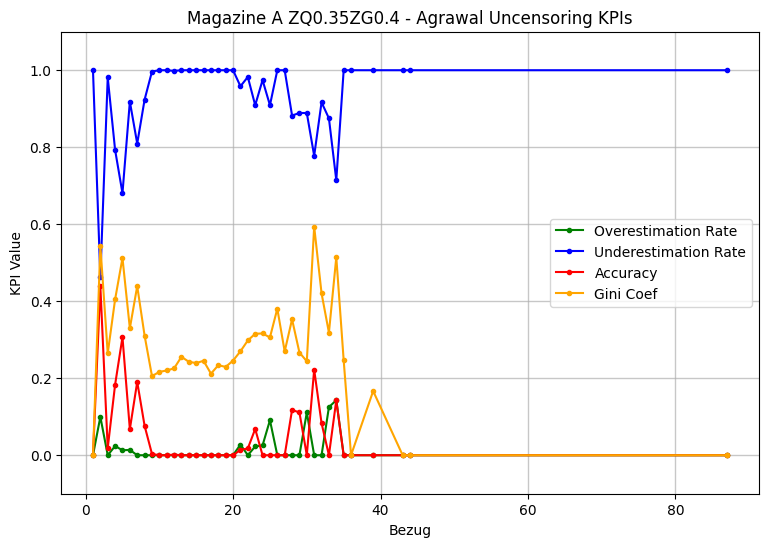

In [22]:
# Graph rates/gini coef by group
df_kpi_Bezug = pd.read_csv('KPI_results/A_20250212_ZQ0.35_ZG0.4_testfile_Agrawal_Bezug_KPI_Bezug.csv', index_col='Bezug')

fig, ax = plt.subplots(figsize=(9,6))
plt.plot(df_kpi_Bezug.index, df_kpi_Bezug['Agrawal_overestimation_rate'], color='green', label = 'Overestimation Rate', marker=".")
plt.plot(df_kpi_Bezug.index, df_kpi_Bezug['Agrawal_underestimation_rate'], color='blue', label = 'Underestimation Rate', marker=".")
plt.plot(df_kpi_Bezug.index, df_kpi_Bezug['Agrawal_accuracy'], color='red', label = 'Accuracy', marker=".")
plt.plot(df_kpi_Bezug.index, df_kpi_Bezug['Agrawal_gini_coefficient'], color='orange', label = 'Gini Coef', marker=".")

ax.set_xlabel('Bezug', fontsize = 10)
ax.set_ylabel('KPI Value', fontsize = 10)
plt.ylim(-0.1,1.1)

ax.set_title('Magazine A ZQ0.35ZG0.4 - Agrawal Uncensoring KPIs')
plt.grid(which = "major", axis = "x", linewidth=1,alpha=0.7)
plt.grid(which = "major", axis = "y", linewidth=1,alpha=0.7)
plt.legend()

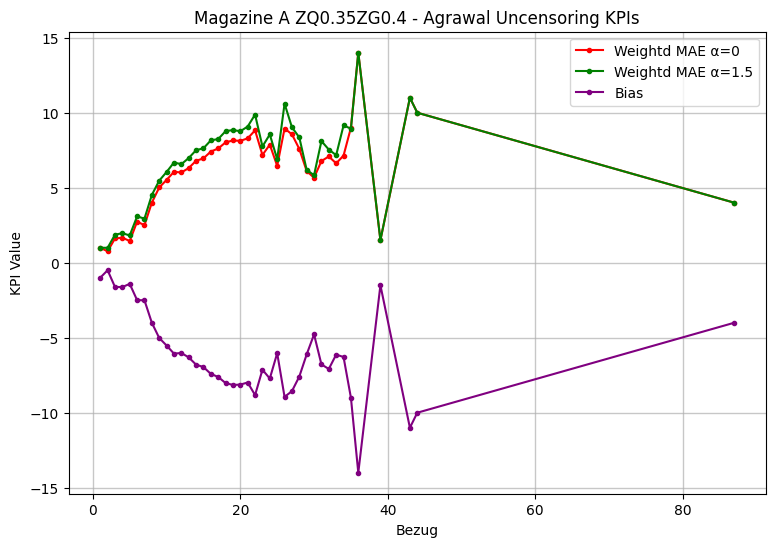

In [23]:
# Graph mae/bias by group
df_kpi_Bezug = pd.read_csv('KPI_results/A_20250212_ZQ0.35_ZG0.4_testfile_Agrawal_Bezug_KPI_Bezug.csv', index_col='Bezug')

fig, ax = plt.subplots(figsize=(9,6))
plt.plot(df_kpi_Bezug.index, df_kpi_Bezug['Agrawal_weighted_mae_0'], color='red', label = 'Weightd MAE α=0', marker=".")
# plt.plot(df_kpi_Bezug.index, df_kpi_Bezug['weighted_mae_0.5'], color='orange', label = 'Weightd MAE α=0.5')
# plt.plot(df_kpi_Bezug.index, df_kpi_Bezug['weighted_mae_1'], color='green',label = 'Weightd MAE α=1')
plt.plot(df_kpi_Bezug.index, df_kpi_Bezug['Agrawal_weighted_mae_1.5'], color='green', label = 'Weightd MAE α=1.5', marker=".")
plt.plot(df_kpi_Bezug.index, df_kpi_Bezug['Agrawal_bias'], color='purple', label = 'Bias', marker=".")

ax.set_xlabel('Bezug', fontsize = 10)
ax.set_ylabel('KPI Value', fontsize = 10)

ax.set_title('Magazine A ZQ0.35ZG0.4 - Agrawal Uncensoring KPIs')
plt.grid(which = "major", axis = "x", linewidth=1,alpha=0.7)
plt.grid(which = "major", axis = "y", linewidth=1,alpha=0.7)
plt.legend()